In [61]:
from google.cloud import storage
from tqdm import tqdm
import pandas as pd
from geopy import distance 
import plotly.express as px
import os
import pyproj
from pyproj import CRS
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
import shapely.ops as ops
from shapely.ops import transform
from functools import partial
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

# to ignore warning created by pyproj.Proj(init="EPSG:4326")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Test Set Generation

**Author:** Madhava Paliyam (madhavapaliyam@gmail.com)

**Description:** Selects images for test set randomly



**Inputs**: Number of points in the test set, minimum seperation distance for points, admin zone to use for each country

**Outputs**: Test set uploaded onto dvc 

#### Method for Selecting Images for Test Set: 
- Filter by points in each admin2 zone 
- Draw bounding box around the points 
- Calculate area of bounding box 
- Sample points in each admin2 zone according to the proportion area that each bounding box covers in comparision to the entire dataset: 


$$npts_{zone} = npts_{total} \times \frac{area_{zone}}{area_{total}}$$

$area_{total}$ is the sum of the areas of the bounding boxes: $$area_{total} = \sum^{admin2\space zones}{area_{zone}}$$

$area_{zone}$ is the area of the bounding box in the admin2 zone calculated using the minimum and maximum latitudes and longitudes. 

$npts_{total}$ is the total number of points needed in the test set sample. 

Lastly, any points are too close together are resampled. 

##### Get database info csv from google cloud 

In [62]:
!dvc pull -q -f 


##### SET SIZE FOR DATASET #####
DATASET_SIZE = 1000 

##### SET MINIMUM SEPERATION #####
MIN_SEPERATION = 200 # m 


##### dictionary to choose admin zone based on country #####
admin_zone_to_use = {'KE': 'admin1', 'UG': 'admin2', 'US': 'admin2'}

##### If there are any zones to not include in the test set, set them here #####
to_drop = {'US': [np.nan], 'KE': [np.nan], 'UG': [np.nan]}

In [ ]:
# Initialize connections to cloud storage
client = storage.Client()

# Read csv with database info 
db = pd.read_csv('gs://street2sat-database-csv/database-info.csv', index_col = 0)

# filter to get rid of images currently being labeled 
db = db[db['being_labeled'] == False]
print(len(db))

db.isna().sum() 


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1498498


input_img             0
latitude          20831
longitude         20831
being_labeled         0
country               6
admin1            24253
admin2           149995
cc                20831
location          20831
test_set              0
time                  0
focal_length          0
pixel_height          0
dtype: int64

In [ ]:
db = db[db['latitude'].notna()]
db = db[db['longitude'].notna()]
len(db)

1477667

#### Calculates the area covered by the sampling in each admin2 zone

In [ ]:
# len(db[(db['admin1'] == 'Illinois') & (db['admin2'] == 'Ford County')])

In [ ]:
def area_for_admin2_km2(filtered_db):
    min_lon = filtered_db['longitude'].min()
    max_lon = filtered_db['longitude'].max()
    min_lat = filtered_db['latitude'].min()
    max_lat = filtered_db['latitude'].max()

    polygon = Polygon(
            [
                [min_lon, min_lat],
                [min_lon, max_lat],
                [max_lon, max_lat],
                [max_lon, min_lat],
            ]
        )


    polygon = ops.transform(
            partial(
                pyproj.transform,
                pyproj.Proj(init="EPSG:4326"),
                pyproj.Proj(
                    proj="aea", lat_1=polygon.bounds[1], lat_2=polygon.bounds[3]
                ),
            ),
            polygon,
        )
    return polygon.area * 1e-6


'''
Returns the number of images to sample from each admin zone based on the formula given above 
'''
def get_areas_km2(db):

    country_admin2_area_images = []
    for cc in tqdm(db['cc'].unique()): 
        print(f"Country Code: {cc}")
        admin_level = admin_zone_to_use[cc]
        print(f"Using admin zone level: {admin_level}")
        
        if admin_level == 'admin1':
            admin_zones = db[db['cc'] == cc].groupby(['admin1']).size().reset_index()
        elif admin_level == 'admin2':
            admin_zones = db[db['cc'] == cc].groupby(['admin1', 'admin2']).size().reset_index()

        if cc in to_drop: 
            for zone_to_drop in to_drop[cc]: 
                admin_zones = admin_zones[admin_zones[admin_level] != zone_to_drop] 

        for _,admin_info in admin_zones.iterrows(): 
            if admin_level == 'admin1':
                filtered_db = db[db[admin_level] == admin_info['admin1']]
            elif admin_level == 'admin2':
                filtered_db = db[(db['admin1'] == admin_info['admin1']) & (db['admin2'] == admin_info['admin2'])]
                
            total_images_for_zone = len(filtered_db)
            area = area_for_admin2_km2(filtered_db) 
            t = (cc, area, total_images_for_zone, dict(admin_info))
            country_admin2_area_images.append(t)
        
    area_info = pd.DataFrame(country_admin2_area_images, columns=['cc', 'area', 'total_images', 'admin_info'])

    area_info['num_images_to_sample'] = (area_info['area'] / area_info['area'].sum()) * DATASET_SIZE

    area_info['num_images_to_sample'] = area_info['num_images_to_sample'].apply(np.ceil)

    return area_info


area_info = get_areas_km2(db)  
print('Calculated images to sample: ', area_info['num_images_to_sample'].sum())
print('Total images: ', area_info['total_images'].sum())
area_info


  0%|          | 0/3 [00:00<?, ?it/s]

Country Code: KE
Using admin zone level: admin1


 33%|███▎      | 1/3 [00:02<00:04,  2.14s/it]

Country Code: UG
Using admin zone level: admin2


 67%|██████▋   | 2/3 [00:07<00:04,  4.22s/it]

Country Code: US
Using admin zone level: admin2


100%|██████████| 3/3 [00:13<00:00,  4.53s/it]

Calculated images to sample:  1048.0
Total images:  1453217


,cc,area,total_images,admin_info,num_images_to_sample
0,KE,53.713220,1640,"{'admin1': 'Bomet', 0: 1640}",1.0
1,KE,1997.707091,6728,"{'admin1': 'Bungoma', 0: 6728}",32.0
2,KE,2869.056811,6800,"{'admin1': 'Busia', 0: 6800}",46.0
3,KE,1924.726918,5059,"{'admin1': 'Homa Bay', 0: 5059}",31.0
4,KE,1871.408454,3282,"{'admin1': 'Kakamega', 0: 3282}",30.0
5,KE,4791.489016,7133,"{'admin1': 'Kericho', 0: 7133}",76.0
6,KE,989.112103,8661,"{'admin1': 'Kisii', 0: 8661}",16.0
7,KE,2860.798534,4537,"{'admin1': 'Kisumu', 0: 4537}",46.0
8,KE,53.555174,537,"{'admin1': 'Laikipia', 0: 537}",1.0
9,KE,0.290753,109,"{'admin1': 'Marakwet District', 0: 109}",1.0


            area  total_images  num_images_to_sample
cc                                                  
KE  37038.160774        104714                 595.0
UG  21077.397732       1258604                 348.0
US   5297.797951         89899                 105.0


<AxesSubplot:title={'center':'Number of Images In Sample'}, ylabel='num_images_to_sample'>

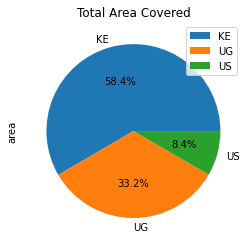

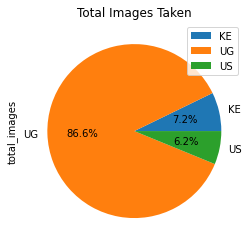

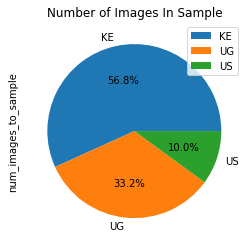

In [73]:
g = area_info.groupby(['cc']).sum()
print(g)
g.plot.pie(y='area', title="Total Area Covered", legend=True, autopct='%1.1f%%')
g.plot.pie(y='total_images', title="Total Images Taken", legend=True, autopct='%1.1f%%')
g.plot.pie(y='num_images_to_sample', title="Number of Images In Sample", legend=True, autopct='%1.1f%%')

In [ ]:
g = area_info.groupby(['cc']).sum()
print(g)
g.plot.pie(y='area', title="Total Area Covered", legend=True, autopct='%1.1f%%')

#### Plot Areas
 
Modify the code below to plot the total points in a certain area

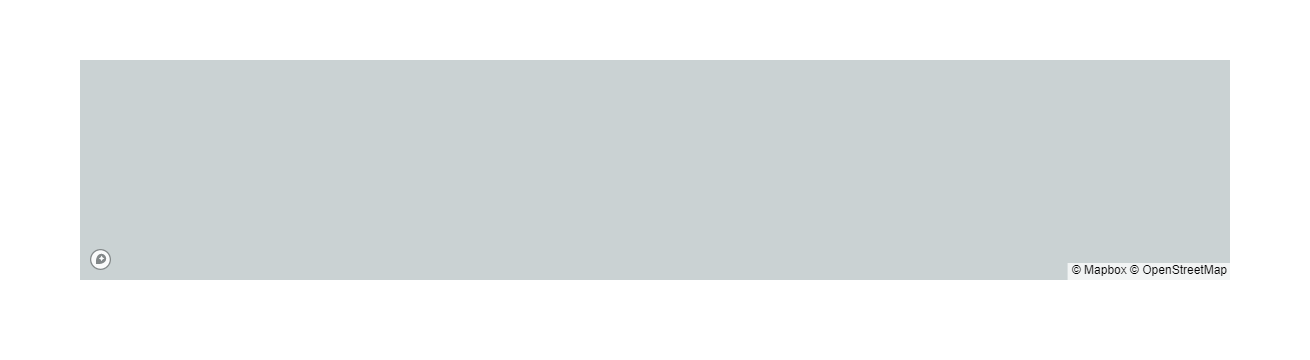

In [51]:
##### Choose admin zone level #####
admin_zone_level = 'admin1'

##### Choose name of the admin zone #####
zone_name = 'Defiance County'


px.set_mapbox_access_token('pk.eyJ1IjoibWFuZ29tYWRoYXZhIiwiYSI6ImNrdWcyNHh2OTIwMmQzMW56eWFibjUwY3QifQ.aQydTOk0ne3KrV87Ib_TrQ')
fig = px.scatter_mapbox(db[db[admin_zone_level] == zone_name], lat='latitude', lon='longitude', size_max=15, zoom=10)
fig.show()

#### Remove any images that are too close together

In [14]:

# ensures that coordinate 1 (c1) is seperated from all the points in points by at least THRESHOLD
def is_far(c1, points):
    for point in points:
        c2 = (point['latitude'], point['longitude'])
        dist = distance.distance(c1, c2).m
        if dist < MIN_SEPERATION: 
            return False 
        
    return True 


# samples points based on country and ensures that they are seperated by at least THRESHOLD 
def sample_geographically_distributed_points(country, admin2, num_points):
    # add 5 images for each entry 
    num_points = num_points + 5

    if country == 'KE': 
        total_points = len(db[db['admin1'] == admin2])
        points = [db[db['admin1'] == admin2].sample(1).iloc[0].to_dict()]

    else: 
        total_points = len(db[db['admin2'] == admin2])
        points = [db[db['admin2'] == admin2].sample(1).iloc[0].to_dict()]
    points_left = num_points - 1

    print(total_points)
    num_times_resampled = 0
    with tqdm(total=num_points) as progress_bar:
        progress_bar.update(1)
        while points_left != 0: 
            if country == 'KE':
                random_sample = db[db['admin1'] == admin2].sample(1).iloc[0].to_dict()
            else: 
                random_sample = db[db['admin2'] == admin2].sample(1).iloc[0].to_dict()
            c1 = (random_sample['latitude'], random_sample['longitude'])
            if is_far(c1, points):
                points.append(random_sample)
                points_left = points_left - 1
                progress_bar.update(1)
                num_times_resampled = 0
            else: 
                num_times_resampled += 1
                if num_times_resampled % 50 == 0: 
                    print(f"Resampled {num_times_resampled} times.")
                if num_times_resampled >= total_points / 4: 
                    print(f"COULD NOT FIND ENOUGH POINTS FOR {admin2}")
                    break 

    return pd.DataFrame(points)

In [38]:
area_info["num_images_to_sample"] = area_info["num_images_to_sample"].astype(int)

In [39]:
area_info

,cc,area,total_images,admin_info,num_images_to_sample
0,KE,53.713220,1640,"{'admin1': 'Bomet', 0: 1640}",1
1,KE,1997.707091,6728,"{'admin1': 'Bungoma', 0: 6728}",14
2,KE,2869.056811,6800,"{'admin1': 'Busia', 0: 6800}",20
3,KE,1924.726918,5059,"{'admin1': 'Homa Bay', 0: 5059}",13
4,KE,1871.408454,3282,"{'admin1': 'Kakamega', 0: 3282}",13
5,KE,4791.489016,7133,"{'admin1': 'Kericho', 0: 7133}",33
6,KE,989.112103,8661,"{'admin1': 'Kisii', 0: 8661}",7
7,KE,2860.798534,4537,"{'admin1': 'Kisumu', 0: 4537}",20
8,KE,53.555174,537,"{'admin1': 'Laikipia', 0: 537}",1
9,KE,0.290753,109,"{'admin1': 'Marakwet District', 0: 109}",1


In [45]:
df_list = []
for r,entry in area_info.iterrows(): 
    
    if entry['num_images_to_sample'] > 2 and 'admin2' in entry['admin_info']: 
        print(entry)
        admin2_df = sample_geographically_distributed_points(entry['cc'], entry['admin_info']['admin2'], entry['num_images_to_sample'])
        df_list.append(admin2_df)

# df_list


cc                                                                            US
area                                                                  584.623392
total_images                                                                3835
admin_info              {'admin1': 'Illinois', 'admin2': 'Ford County', 0: 3835}
num_images_to_sample                                                           4
Name: 24, dtype: object
3835


100%|██████████| 9/9 [00:00<00:00, 13.69it/s]


cc                                                                                US
area                                                                      964.288813
total_images                                                                    5355
admin_info              {'admin1': 'Illinois', 'admin2': 'Iroquois County', 0: 5355}
num_images_to_sample                                                               7
Name: 27, dtype: object
5355


100%|██████████| 12/12 [00:00<00:00, 12.70it/s]


cc                                                                            US
area                                                                    607.1849
total_images                                                                3516
admin_info              {'admin1': 'Illinois', 'admin2': 'Knox County', 0: 3516}
num_images_to_sample                                                           5
Name: 28, dtype: object
3516


100%|██████████| 10/10 [00:00<00:00, 12.29it/s]


cc                                                                              US
area                                                                    390.258651
total_images                                                                  3425
admin_info              {'admin1': 'Illinois', 'admin2': 'McLean County', 0: 3425}
num_images_to_sample                                                             3
Name: 30, dtype: object
3425


100%|██████████| 8/8 [00:00<00:00, 10.96it/s]


cc                                                                                US
area                                                                      504.087393
total_images                                                                    4366
admin_info              {'admin1': 'Illinois', 'admin2': 'Tazewell County', 0: 4366}
num_images_to_sample                                                               4
Name: 31, dtype: object
4366


100%|██████████| 9/9 [00:00<00:00, 13.14it/s]


cc                                                                               US
area                                                                     355.262365
total_images                                                                   3481
admin_info              {'admin1': 'Indiana', 'admin2': 'Delaware County', 0: 3481}
num_images_to_sample                                                              3
Name: 36, dtype: object
3481


100%|██████████| 8/8 [00:00<00:00, 13.32it/s]


cc                                                                             US
area                                                                   373.395364
total_images                                                                14348
admin_info              {'admin1': 'Ohio', 'admin2': 'Paulding County', 0: 14348}
num_images_to_sample                                                            3
Name: 52, dtype: object
14348


100%|██████████| 8/8 [00:01<00:00,  5.80it/s]


In [46]:
test_set_concat = pd.concat(df_list)
len(test_set_concat)


64

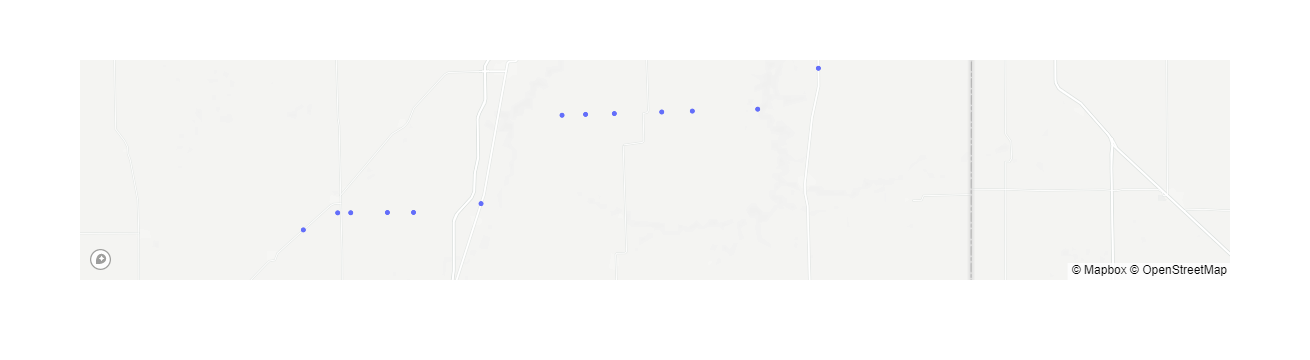

In [47]:
px.set_mapbox_access_token('pk.eyJ1IjoibWFuZ29tYWRoYXZhIiwiYSI6ImNrdWcyNHh2OTIwMmQzMW56eWFibjUwY3QifQ.aQydTOk0ne3KrV87Ib_TrQ')
fig = px.scatter_mapbox(test_set_concat, lat='latitude', lon='longitude', size_max=15, zoom=10)
fig.show()

#### Run the cell below if you want to download the images locally

In [48]:
gcloud_uploaded_bucket = client.bucket('street2sat-uploaded')

if not os.path.exists('test_set'):
    os.makedirs('test_set')

for i,point in test_set_concat.iterrows():
    blob = gcloud_uploaded_bucket.blob(point['input_img'].replace('gs://street2sat-uploaded/', ''))
    try: 
        blob.download_to_filename(f'test_set/{i}.jpg')
    except: 
        t = point['input_img'].replace('gs://street2sat-uploaded/', '')
        print(f'image not found: {t}')

image not found: USA/2021-08-20-croptour/G0016105.JPG
image not found: USA/2021-08-20-croptour/G0028893.JPG
image not found: USA/2021-08-20-croptour/G0028571.JPG
image not found: USA/2021-08-20-croptour/G0028810.JPG


#### Run the cell below if you want to update the test set csv with the generated test set 

In [49]:
test_set_concat.to_csv('../data/test.csv')

In [50]:
(test_set_concat['being_labeled'] == False).all()

True

In [ ]:
# TODO: upload to dvc 